# **Introduction: Why Parallel Scripting?**

Parsl is a simple scripting library for executing dataflow-based dependency in Python.

Parsl allows you to define a dependency based graph of what various applications need in order to be executed.

While you can write arbitrary programs directly in Pars, one of the things Parsl is good at is acting like a structured "shell" language. It runs programs concurrently as soon as their inputs are available, reducing the need for complex parallel programming. Parsl expresses workflow in a portable fashion: The same script can run on multicore computers, clusters, clouds, grids, and supercomputers.

In every example, you will find a parsl script that executes the workflow pattern as well as the equivalent swift code that the parsl was created from. In most cases, there is also a visual representation of the workflow.

In this tutorial, you will be able to first try a few Parsl examples (examples 1-3) on your local machine, to get a sense of the language. Then, in examples 4-6 you will run similar workflows on any resource you may have access to, such as clouds (Amazon Web Services), Cray HPC systems, clusters etc, and see how more complex workflows can be expressed with Parsl scripts.

Examples 4-6 can also be run on a local multicore machine if desired.

To run the tutorial, ensure that Python (3.5+) and parsl 0.2 is installed on the machine you would be using to run the tutorial on.

**To install Parsl:**

Download Parsl:
    $ git clone https://github.com/Parsl/parsl.git parsl
Install:
    $ cd parsl

    $ python3 setup.py install
Setup the Parsl tutorial:

    $ git clone https://github.com/Parsl/parsl-tutorial.git parsl_tutorial

    $ cd parsl_tutorial

    $ bash setup.sh
    
Doing this will add the sample applications simulate and stats (mock "science" applications) and some other functionalities to your local $PATH for you to run the tutorial

# Tutorial Section One

This section will be a walk-through of the getting a simple "mock" science application running with parsl on your local machine (localhost).

## Example 1: Run a single application under Parsl
**The first swift script, p1.py, runs simulate.sh to generate a single random number. It writes the number to a file.**
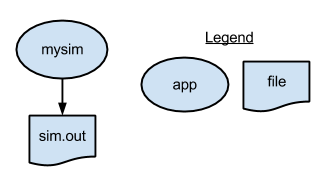

In [ ]:
#p1.py
from parsl import App, DataFlowKernel, ThreadPoolExecutor
from parsl.dataflow.futures import Future

# Define our workers and dfk.
# In this case, we are running locally and specifying a max of 4
# concurrent threads
workers = ThreadPoolExecutor(max_workers=4)
dfk = DataFlowKernel(workers)

outputfile = "sim"


@App('bash', dfk)
def setup() -> Future:
    """Set PATH to contain apps"""
    cmd_line = "export PATH=$PWD/../app:$PATH"


@App('bash', dfk)
def mysim(stdout: str="output/" + outputfile + ".out",
          stderr: str="output/" + outputfile + ".err") -> Future:
    """Set this example up as a bash app, which will call
    a command line utility, in this case simulate"""
    cmd_line = "simulate"


if __name__ == '__main__':
    setup().result()
    mysim()

## Example 2:  Running an ensemble of many apps in parallel with a "foreach" loop
**The p2.py script introduces the foreach parallel iteration construct to run many concurrent simulations.**
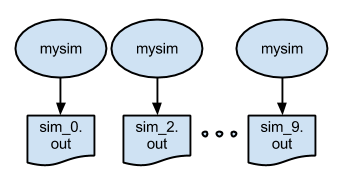

In [ ]:
#p2.py

from parsl import App, DataFlowKernel, ThreadPoolExecutor
from parsl.dataflow.futures import Future

workers = ThreadPoolExecutor(max_workers=4)
dfk = DataFlowKernel(workers)


@App('bash', dfk)
def setup()-> Future:
    """Set this example up as a bash app,
    which will call a command line argument"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"


@App('bash', dfk)
def mysim(stdout: str="sim.out", stderr: str="sim.err")-> Future:
    """Run command line utility simulate with no params"""
    cmd_line = "simulate"


@App('python', dfk)
def many_sims(runs: int=10)-> Future:
    """launch many concurrent simulations"""
    for i in range(runs):
        outputfile = "sim_{}".format(i)
        mysim(stdout="output/" + outputfile + ".out",
              stderr="output/" + outputfile + ".err")


if __name__ == '__main__':
    # use .result() function to force execution of next step to wait
    setup().result()
    many_sims()

## Example 3: Analyzing results of a parallel ensemble

**After all the parallel simulations in an ensemble run have completed, it is typically necessary to gather and analyze their results with some kind of post-processing analysis program or script. p3.py introduces such a postprocessing step. In this case, the files created by all of the parallel runs of simulation.sh will be averaged by the trivial "analysis application" stats.sh:**

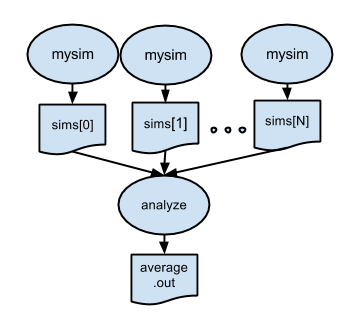

In [ ]:
from parsl import App, DataFlowKernel, ThreadPoolExecutor
from parsl.dataflow.futures import Future

workers = ThreadPoolExecutor(max_workers=4)
dfk = DataFlowKernel(workers)


@App('bash', dfk)
def setup()-> Future:
    """set PATH"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"


@App('bash', dfk)
def mysim(stdout: str="sim.out", stderr: str="sim.err", outputs: list=[])-> Future:
    """Call simulate on the command line"""
    cmd_line = "simulate"


@App('python', dfk)
def start_many_sims(num_tasks: int=10)-> Future:
    """Start many concurrent simulations on the command line"""
    outputs = []
    for i in range(0, num_tasks):
        outputfile = "output/sim_{}".format(i)
        a = mysim(stdout=outputfile + ".out", stderr=outputfile +
                  ".err", outputs=[outputfile + ".out"])
        outputs.append(a)
    return outputs


@App('bash', dfk)
def stats(inputs: list=[],
          stderr: str='output/average.err',
          stdout: str='output/average.out')-> Future:
    """call stats cli utility with all simulations ans inputs"""
    cmd_line = "stats {}".format(" ".join(inputs))


if __name__ == '__main__':
    # Make execution wait until after path is set
    setup().result()
    results = [i[1][0].result() for i in start_many_sims().result()]
    print(results)
    # Get filenames of simulation outputs
    # Get futures that the stats function will depend on.
    # pass dependencies into stats function
    stats(inputs=results)

# Tutorial Section Two

This section introduces the aspects of running on remote computational resources. We will go into the configuration aspects that allow parsl to run your applications on computation resources.

## Example 4: Running a simple app on remote node

In p4.py, there is a simple app which takes a file containing random numbers and sort them before returning a sorted output. In the p4 folder we have a file, unsorted.txt, which contains 100 random integers ranging from 0 to 99 and we wish to run the job on a remote computational resource. Ensure that you have configured parsl for your target remote site.

In [ ]:
#!/usr/bin/env python3

from parsl import App, DataFlowKernel, IPyParallelExecutor
from parsl.execution_provider.midway.slurm import Midway
from parsl.dataflow.futures import Future

"""From now on, the tutorial applications are written to run on Midway,
a cluster located at the University of Chicago Research Computing Center
They have also been tested locally on both Mac and Ubuntu Linux.
In order to run them locally, either start an
IPyParallel cluster controller on your machine
or change the workers to something like this:
workers = ThreadPoolExecutor(max_workers=NUMBER OF CORES)"""

# This is the default file location.
# I've left it in on the first example for clarity.
workers = IPyParallelExecutor(
    engine_json_file='~/.ipython/profile_default/security/ipcontroller-engine.json')
dfk = DataFlowKernel(workers)


@App('python', dfk)
def midway_setup()-> Future:
    """Set site-specific options"""
    conf = {"site": "pool1",
            "queue": "bigmem",
            "maxnodes": 4,
            "walltime": '00:04:00',
            "controller": "10.50.181.1:50001"}

    pool1 = Midway(conf)
    pool1.scale_out(1)
    pool1.scale_out(1)


@App('bash', dfk)
def setup()-> Future:
    """Set Path"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"

# Set this example up as a bash app, which will call a command line argument


@App('bash', dfk)
def sort(unsorted: str, stdout: str="output/sorted.out",
         stderr: str="output/sorted.err")-> Future:
    """Call sort executable on file `unsorted`"""
    cmd_line = "sort {}".format(unsorted)


if __name__ == '__main__':
    setup()
    unsorted = "unsorted.txt"
    sorted = "output/sorted.txt"
    sort(unsorted, stdout=sorted)

## Example 5: Running a parallel ensemble on compute resources

p5.py will run our mock "simulation" applications on compute nodes. The script is similar to p3.py, but specifies that each simulation app invocation should additionally return the log file which the application writes to stderr. In p3.py the apps simulation and stats called the binaries stats and simulate which are available on the local machine and is present in the system path.

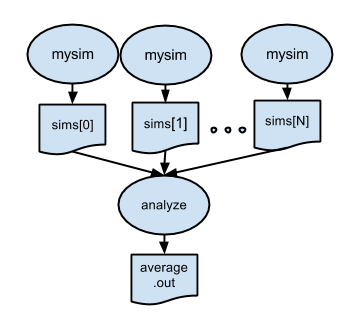

In [ ]:
#!/usr/bin/env python3

from parsl import App, IPyParallelExecutor, DataFlowKernel
from parsl.execution_provider.midway.slurm import Midway
from parsl.dataflow.futures import Future

"""From now on, the tutorial applications are written to run on Midway,
a cluster located at the
University of Chicago Research Computing Center
They have also been tested locally on both Mac and Ubuntu Linux.
In order to run them locally, either
start an IPyParallel cluster controller on your machine
or change the workers to something like this:
workers = ThreadPoolExecutor(max_workers=NUMBER OF CORES)
This example is the same as p3.py, except run on Midway
"""

workers = IPyParallelExecutor(
    engine_json_file='~/.ipython/profile_default/security/ipcontroller-engine.json')
dfk = DataFlowKernel(workers)


@App('python', dfk)
def midway_setup()-> Future:
    """Set site-specific options"""
    conf = {"site": "pool1",
            "queue": "bigmem",
            "maxnodes": 4,
            "walltime": '00:04:00',
            "controller": "10.50.181.1:50001"}

    pool1 = Midway(conf)
    pool1.scale_out(1)
    pool1.scale_out(1)


@App('bash', dfk)
def setup()-> Future:
    """Set path"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"


@App('bash', dfk)
def mysim(stdout: str="sim.out", stderr: str="sim.err")->Future:
    """Call simulate from the cli"""
    cmd_line = "simulate"


@App('python', dfk)
def start_many_sims(num_tasks: int=10)-> Future:
    """Start many concurrent simulations on the command line"""
    outputs = []
    for i in range(0, num_tasks):
        outputfile = "output/sim_{}".format(i)
        a = mysim(stdout=outputfile + ".out", stderr=outputfile +
                  ".err", outputs=[outputfile + ".out"])
        outputs.append(a)
    return outputs


@App('bash', dfk)
def stats(inputs: list=[],
          stderr: str='output/average.err',
          stdout: str='output/average.out')-> Future:
    """call stats cli utility with all simulations ans inputs"""
    cmd_line = "stats {}".format(" ".join(inputs))


if __name__ == '__main__':
    # Make execution wait until after path is set
    setup().result()
    results = [i[1][0].result() for i in start_many_sims().result()]
    # Get filenames of simulation outputs
    # Get futures that the stats function will depend on.
    # pass dependencies into
    out = stats(inputs=results)

## Example 6: Specifying more complex workflow patterns

p6.py expands the workflow pattern of p5.py to add additional stages to the workflow. Here, we generate a dynamic seed value that will be used by all of the simulations, and for each simulation, we run a pre-processing application to generate a unique "bias file". This pattern is shown below, followed by the parsl script.
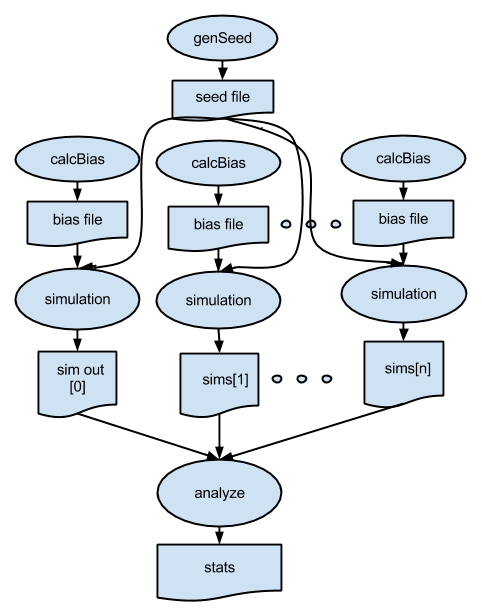

In [ ]:
#!/usr/bin/env python3


from parsl import App, DataFlowKernel, IPyParallelExecutor
from parsl.execution_provider.midway.slurm import Midway
from parsl.dataflow.futures import Future

workers = IPyParallelExecutor(
    engine_json_file='~/.ipython/profile_default/security/ipcontroller-engine.json')
dfk = DataFlowKernel(workers)

"""From now on, the tutorial applications are written to run on Midway,
a cluster located at the University of Chicago Research Computing Center.
They have also been tested locally on both Mac and Ubuntu Linux.
In order to run them locally, either start an
IPyParallel cluster controller on your machine
or change the workers to something like this:

workers = ThreadPoolExecutor(max_workers=NUMBER OF CORES)

This example is the same as p5.py, except with more layers of dependence added.

"""


@App('python', dfk)
def midway_setup()-> Future:
    """Set site-specific options for midway"""
    conf = {"site": "pool1",
            "queue": "bigmem",
            "maxnodes": 4,
            "walltime": '00:04:00',
            "controller": "10.50.181.1:50001"}

    pool1 = Midway(conf)
    pool1.scale_out(1)
    pool1.scale_out(1)


@App('bash', dfk)
def setup()-> Future:
    """set PATH"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"


# Set this example up as a bash app, which will call a command line argument


@App('bash', dfk)
def simulation(timesteps: int, sim_range: int, bias_file: str, scale: int, sim_count: int,
               seed_file: str, stdout: str='sim.out',  stderr: str='sim.err')->Future:
    """Call simulation from cli with input values from seed and bias files"""
    cmd_line = 'simulate -t {} -r {} -B {} -x {} -n {} -S {}'.format(
        timesteps, sim_range, bias_file, scale, sim_count, seed_file)
    print()


@App('python', dfk)
def start_many_sims(steps: int, sim_range: int, sim_count: int,
                    log_file: str, num_tasks: int=10, inputs=[])-> Future:
    """Launch many concurrent simulations with input values
    from seed and bias files"""
    outputs = []
    deps = []
    for i in range(0, num_tasks):
        outputfile = "output/sim_{}".format(i)
        biasfile = "output/bias_{}.out".format(i)
        a = simulation(steps, sim_range, biasfile, 1000000, sim_count,
                       'output/seed.out', stdout=outputfile + ".out",
                       stderr=log_file)
        outputs.append(outputfile + ".out")
        deps.append(a)
    return outputs, deps


@App('bash', dfk)
def stats(deps: str=[], inputs: str=[], stderr: str='output/average.err',
          stdout: str='output/average.out')->Future:
    """Launch stats calculation with all input files passed through `inputs`"""
    cmd_line = "stats {}".format(" ".join(inputs))


@App('bash', dfk)
def gen_seed(n_seeds: int, r: int, generate_script: str,
             stdout: str='output/seed.out', stderr: str='output/seed.err', outputs=[])->Future:
    """Generate seed file from simulate executable"""
    cmd_line = "{} -r {} -n {}".format(generate_script, r, n_seeds)


@App('bash', dfk)
def calc_bias(bias_range: int, n_values: int, bias_script: str,
              stdout: str='bias.out', stderr: str='bias.err')->Future:
    """Generate bias file from simulate executable"""
    cmd_line = "{} -r {} -n {}".format(bias_script, bias_range, n_values)


@App('python', dfk)
def start_many_bias(bias_range: int, n_values: int, bias_script: str,
                    log_file: str, num_tasks: int=10)->Future:
    """Launch many concurrent bias simulations
    with input values from seed files"""
    outputs = []
    deps = []
    for i in range(0, num_tasks):
        outputfile = "output/bias_{}".format(i)
        a = calc_bias(bias_range, n_values, bias_script,
                      stdout=outputfile + ".out", stderr=log_file)
        outputs.append(outputfile + ".out")
        deps.append(a)
    return outputs, deps


if __name__ == '__main__':
    setup()
    deps = []

    # Generate seed file
    seedfile = 'seed.out'
    seed = gen_seed(1, 200000, "simulate", outputs=[
                    'output/seed.out'])[1]

    # Generate a bias file for each simulation
    biases = start_many_bias(1000, 20, 'simulate', "output/bias.err")

    steps = 1
    sim_range = 100
    n_sim = 10
    # run simulations only after seed and bias files are ready
    all_sims = start_many_sims(
        steps, sim_range, n_sim, "output/sims.err", inputs=[biases])
    # run stats only after all sims are complete
    averages = all_sims.result()[0]
    stats(inputs=averages)

## Example 7: MPI Hello

p7.py is a basic "Hello World!" example that shows you how to run MPI applications. Here we have a simple MPI code mpi_hello.c that has each MPI rank sleep for a user-specified duration and then print the processor name on which the rank is executing followed by "Hello World!". Note that unlike the previous examples the mpi application is not called directly in the app definition. Instead it is called as an argument to mpiwrap. mpiwrap manages the system specific invocation such as mpiexec or srun, required to launch an MPI task and takes the number of processes to launch as an argument followed by the path to the mpiapp and it’s arguments.

In [ ]:
#!/usr/bin/env python3

from parsl import App, IPyParallelExecutor, DataFlowKernel
import os
from parsl.dataflow.futures import Future
from parsl.execution_provider.midway.slurm import Midway

"""From now on, the tutorial applications are written to run on Midway,
a cluster located at the University of Chicago Research Computing Center
They have also been tested locally on both Mac and Ubuntu Linux.
In order to run them locally,
either start an IPyParallel cluster controller on your machine
or change the workers to something like this:
workers = ThreadPoolExecutor(max_workers=NUMBER OF CORES)
"""

workers = IPyParallelExecutor()
dfk = DataFlowKernel(workers)


@App('python', dfk)
def midway_setup()-> Future:
    """Set Midway site-specific options"""
    conf = {"site": "pool1",
            "queue": "bigmem",
            "maxnodes": 4,
            "walltime": '00:04:00',
            "controller": "10.50.181.1:50001"}

    pool1 = Midway(conf)
    pool1.scale_out(1)
    pool1.scale_out(1)


@App('bash', dfk)
def setup()-> Future:
    """Set path"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"


@App('bash', dfk)
def compile_app(compiler: str="mpicc")->Future:
    """Compile mpi app with mpicc"""
    cmd_line = "{} ../mpi/mpi_hello.c -o mpi_hello".format(compiler)


@App('bash', dfk)
def mpi_hello(time: int, nproc: int, app: str="mpi_hello",
              mpilib: str="mpiexec", stdout: str="mpi_hello.out",
              stderr: str="mpi_hello.err")-> Future:
    """Call compiled mpi executable with mpilib.
    Works natively for openmpi mpiexec, mpirun, orterun, oshrun, shmerun
    mpiexec is default"""
    cmd_line = "{} -np {} {} {}".format(mpilib, nproc, app, time)


@App('python', dfk)
def many_mpi_hello(time: int, nproc: int, app: str, n_runs: int):
    """Call mpi hello world n_runs times"""
    fus = []
    for i in range(n_runs):
        fus.append(mpi_hello(time, nproc, app,
                             stdout="output/mpi_hello_{}.out".format(i),
                             stderr="output/mpi_hello_{}.err".format(i)))
    return fus


if __name__ == '__main__':
    setup()
    # use .result() to make the execution wait until the app has compiled
    compile_app().result()

    app = "{}/mpi_hello".format(os.getcwd())
    many_mpi_hello(1400000, 10, app, 10)

## Example 8: A two stage MPI workflow

Expanding on the previous example, we will look at a simple workflow that has a distributed phase followed by an aggregation phase. For this example we are using an MPI program mpi_pi.c that calculates the value of Pi in a distributed fashion.

In [ ]:
#!/usr/bin/env python3
import os

from parsl import App, DataFlowKernel, IPyParallelExecutor
from parsl.dataflow.futures import Future
from parsl.execution_provider.midway.slurm import Midway

"""From now on, the tutorial applications are written to run on Midway,
a cluster located at the University of Chicago Research Computing Center
They have also been tested locally on both Mac and Ubuntu Linux.
In order to run them locally,
either start an IPyParallel cluster controller on your machine
or change the workers to something like this:
workers = ThreadPoolExecutor(max_workers=NUMBER OF CORES)
"""

workers = IPyParallelExecutor()
dfk = DataFlowKernel(workers)


@App('python', dfk)
def midway_setup()-> Future:
    """Set midway specific site options"""
    conf = {"site": "pool1",
            "queue": "bigmem",
            "maxnodes": 4,
            "walltime": '00:04:00',
            "controller": "10.50.181.1:50001"}

    pool1 = Midway(conf)
    pool1.scale_out(1)
    pool1.scale_out(1)


@App('bash', dfk)
def setup()-> Future:
    """Set PATH"""
    cmd_line = "export PATH=$PWD/../app/:$PATH"


@App('bash', dfk)
def compile_app()->Future:
    """Compile MPI app with mpi compiler"""
    cmd_line = "mpicc ../mpi/pi.c -o mpi_pi"


@App('bash', dfk)
def mpi_pi(nproc: int, intervals: int, duration: int, app: str="mpi_pi",
           mpilib: str='mpiexec', stdout: str="mpi_pi.out",
           stderr: str="mpi_pi.err")-> Future:
    """Call mpi_pi from cli"""
    cmd_line = "{} -np {} {} {} {}".format(mpilib,
                                           nproc, app, intervals, duration)


@App('python', dfk)
def many_mpi_pi(time: int, nproc: int, app: int, intervals: int,
                duration: int, n_runs: int=10)-> Future:
    """Call many copies of mpi_pi concurrently"""
    fus = []
    files = []
    for i in range(n_runs):
        outfile = "output/mpi_pi_{}.out".format(i)
        fus.append(mpi_pi(nproc, app, intervals, duration, stdout=outfile,
                          stderr="output/mpi_pi_{}.err".format(i)))
        files.append(outfile)
    return fus, files


@App('bash', dfk)
def summarize(pi_runs: list=[], deps: list=[], stdout: str="summarize.out",
              stderr: str="summarize.err")-> Future:
    """Create summary file"""
    cmd_line = 'grep "^pi" {}'.format(" ".join([str(i) for i in pi_runs]))


if __name__ == '__main__':
    setup()
    # use .result() to make the execution wait until the app has compiled
    compile_app().result()

    """
    get futures that stats depends on.
    Because we call with bash apps, we need to get the dependent futures separately
    if we were to rewrite with all python apps returning filenames, we could simply pass
    the futures themselves into the next layer of apps and execution would wait automatically
    """

    app = "{}/mpi_pi".format(os.getcwd())
    deps, files = many_mpi_pi(48, 10, app, 10, 10).result()
    summarize(pi_runs=files, deps=[dep.result() for dep in deps],
              stdout='output/summarize.out', stderr='output/summarize.err')